### Loading in the dataset
* We can load in a data set using load_dataset. We are then dealing with a DatasetDict which contains 2 datsets.
* You can check what the dataset splits by using `get_dataset_split_names`.

### Dataset
*  The dataset is a dictionairy which tells you more about the dataset itself.
    * So it contains the features which is usually text and the number of rows.
* The actual data of the set can be accessed by noting the features name as a index

In [1]:
from datasets import load_dataset, get_dataset_split_names
import string
from typing import Set


def loadDataSet():
    allowed_chars = {ch for ch in string.printable} | {"\n"}
    ds = load_dataset("roneneldan/TinyStories", streaming=True)
    
    training_set = ds["train"] # type: ignore
    validation_set = ds["validation"] # type: ignore
    with open("trainingText.clean.txt", "w") as f:
        for ex in training_set:
            text = ex["text"] # type:ignore
            filtered = "".join(ch.lower() for ch in text if ch in allowed_chars)
            f.write(filtered + "\n")
    with open("validationText.txt", "w") as f:
        for ex in validation_set:
            text = ex["text"] # type: ignore
            filtered = "".join(ch.lower() for ch in text if ch in allowed_chars)
            f.write(filtered + "\n")
loadDataSet()

/home/ziaad/code/azure/GPT/GPTvenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Going from Text to Integers
To operate on data we want these in a numerical representation.  \
A easy way to do this is to transform each char to a specific value. \
We can thus make a lookup table. Before we can do this, we have to see what the range of data is that we operate on

### Learned
* Don't load more than 10^10 chars, otherwise mem crashes
* string.printable exists



In [4]:
import string
def define_vocab(size=1000000000): 
    vocab: Set
    with open("trainingText.clean.txt", "r") as f:
        sample = f.read(size)
        vocab = set(sample)
        return sorted(vocab)

vocab = define_vocab()

### Defining a mapping

In [5]:

def mapping(vocab):
    mapping_stoi = {ch:i for i, ch in enumerate(vocab)}
    mapping_itos =  {i:ch for i, ch in enumerate(vocab)}
    return  mapping_stoi, mapping_itos 
print(len(vocab))

mapping_stoi, mapping_itos = mapping(vocab)

def stoi(string):
    return mapping_stoi[string]

def itos(integer):
    return mapping_itos[integer]

print(stoi('\n'), itos(5))
print(type(stoi))

70
1 #
<class 'function'>


#### Frequency measurement
* We want to calculate how often a certain char appears after another char
    * Each char can be followed by any other char. We need to do this for all chars thus we need a matrix of size (vocab.size, vocab.size)
    * We can for now use a NumPy array and later convert this into a Pytorch matrix
* We need to parse the entire file thus we need to think probably about how to operate on this large amount of data.
    * Loading the entire file into memory won't work -> too big.
    * We can load the data into chunks ->
        * How will we handle the edge cases?
        * Always keep track of the first and last char.
        * Couple the last char to the first char -> Edge cases: 
            * First block doesn't have a previous one so skip this.
            * The last block doesn't have a upcoming a 'first' one.

In [9]:
import numpy as np

chunk_size = 8*1024*1024
def load_chunking(path="trainingText.clean.txt", size=chunk_size):
    with open(file=path, mode='r', encoding="utf-8", buffering=size) as f:
        while True:
            s = f.read(size)
            if not s:
                break
            else: yield s


def count_bigrams(C, path, mapping_stoi):
    carry = None
    for chunk in load_chunking(path):
        if not chunk:
            continue
        if carry is not None:
            C[mapping_stoi[carry], mapping_stoi[chunk[0]]] += 1
        for a, b in zip(chunk, chunk[1:]):
            C[mapping_stoi[a], mapping_stoi[b]] +=1
        carry = chunk[-1]
    return C

def setupBigram(vocabSize):
    C = np.zeros((vocabSize, vocabSize), dtype=np.int64 )
    loadedBigram = count_bigrams(C,"trainingText.clean.txt",mapping_stoi)
    print("Shape:", C.shape)         # (70, 70)
    print("Total pairs:", C.sum())   # should be total_chars_in_file - 1
    print("No negatives:", (C >= 0).all())

    return loadedBigram

bigram = setupBigram(len(vocab))
print(bigram)


Shape: (70, 70)
Total pairs: 1900091600
No negatives: True
[[      0      18       1 ...       0       0       0]
 [     17 9124617   15422 ...       0       0       3]
 [      8 1796240   30110 ...       1       0       2]
 ...
 [      0       0       0 ...       0       0       0]
 [      0       3       0 ...       0       1       0]
 [      0       5       2 ...       0       0       4]]


### Visualize Heatmap for the matrix

{0: '\t', 1: '\n', 2: ' ', 3: '!', 4: '"', 5: '#', 6: '$', 7: '%', 8: '&', 9: "'", 10: '(', 11: ')', 12: '*', 13: '+', 14: ',', 15: '-', 16: '.', 17: '/', 18: '0', 19: '1', 20: '2', 21: '3', 22: '4', 23: '5', 24: '6', 25: '7', 26: '8', 27: '9', 28: ':', 29: ';', 30: '<', 31: '=', 32: '>', 33: '?', 34: '@', 35: '[', 36: '\\', 37: ']', 38: '_', 39: '`', 40: 'a', 41: 'b', 42: 'c', 43: 'd', 44: 'e', 45: 'f', 46: 'g', 47: 'h', 48: 'i', 49: 'j', 50: 'k', 51: 'l', 52: 'm', 53: 'n', 54: 'o', 55: 'p', 56: 'q', 57: 'r', 58: 's', 59: 't', 60: 'u', 61: 'v', 62: 'w', 63: 'x', 64: 'y', 65: 'z', 66: '{', 67: '|', 68: '}', 69: '~'}
['\t', '\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~']


/home/ziaad/code/azure/GPT/GPTvenv/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/ziaad/code/azure/GPT/GPTvenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


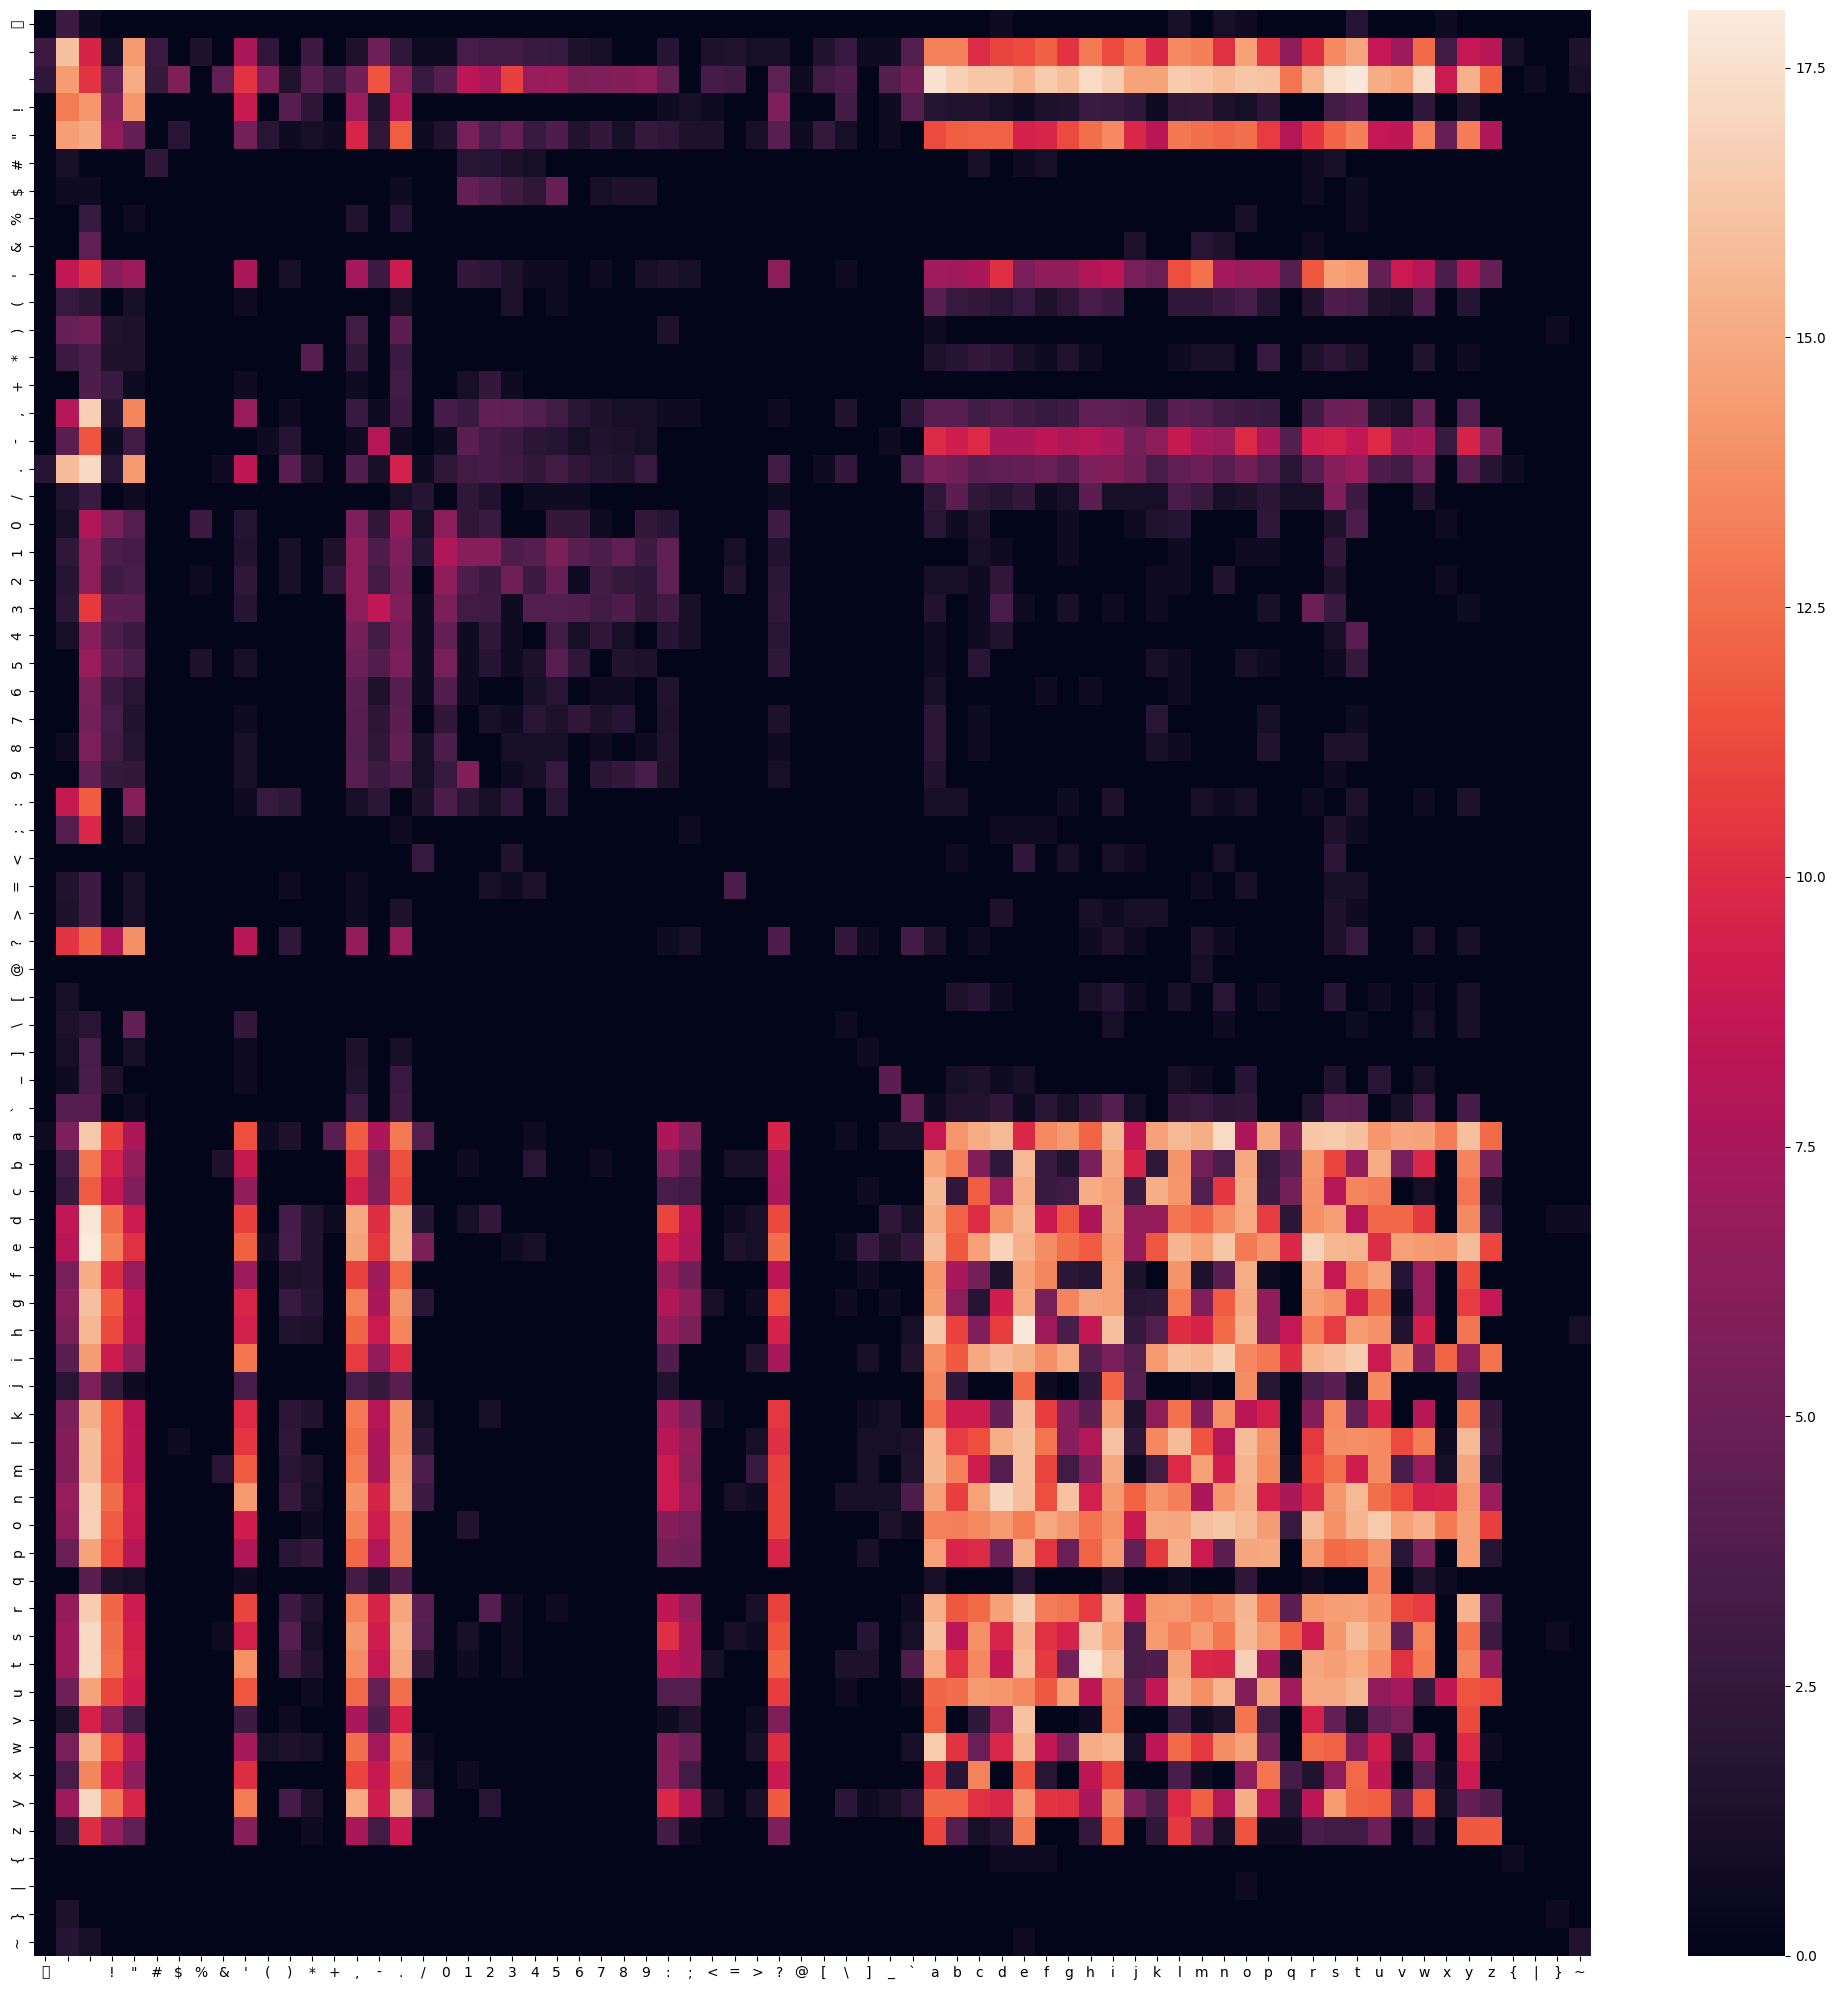

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
print(mapping_itos)
labels = [mapping_itos[i] for i in range(len(mapping_itos))]
print(labels)
plt.figure(figsize=(20,20))
sns.heatmap(np.log1p(bigram), xticklabels = labels, yticklabels=labels)
plt.tight_layout()
plt.show()

### Going from frequency to probability
Right now we have a matrix in the form:
$$
\text{cols: } A \; B \; C \; \cdots \; Z \\
\text{rows:}
\begin{bmatrix}
0 & 4 & 2 & \cdots & 1 \\
1 & 0 & 3 & \cdots & 2 \\
0 & 5 & 0 & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
2 & 0 & 1 & \cdots & 0
\end{bmatrix}
$$

We want to transform this matrix of frequencies into a matrix of probabilties 
* Each row must sum up to 1. -> For all rows: \
    *Take the sum of a row, \
        * For each col across this row -> divide by this sum. 



In [ ]:
def freq_to_prob_matrix(bigram):
    sum_rows = bigram.sum(axis=1, keepdims=True)
    normalized_bigram = bigram / sum_rows
    return normalized_bigram

normalizedBigram = freq_to_prob_matrix(bigram)
print(normalizedBigram)

[[0.00000000e+00 5.80645161e-01 3.22580645e-02 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 3.22580645e-02
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 6.45161290e-02
  0.00000000e+00 6.45161290e-02 3.22580645e-02 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 1.61290323e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 3.22580645e-02
  0.0000

### Bigrams accuracy
We would want to investigate if these probabilities that we have computed align well with reality. To do so we can:\
* For each char X,  take a look  at the next char Z.  
    * Go to that row of X, search up the probability of Z 
    * Compute the $$ -\log(P(Z|X))$$ 
        * The - log function increases exponentially when it approaches 0 and is 0 when it is 1. Perfect for describing how off we are.

In [ ]:
def cross_entropy(normalizedBigram):
    negative_log_bigram = -np.log(normalizedBigram)
    